In [44]:
%matplotlib inline

import json
import os
import random
import re
import unicodedata
from dateutil import parser

import numpy as np
import matplotlib as plt
import pandas as pd
import unirest

import processing

In [149]:
tweets_data = []

for i in range(1,6):
    data = 'data/data' + str(i) + '.txt'
    tweets_file = open(data, "r")
    for line in tweets_file:
        try:
            tweet = json.loads(line)
            tweets_data.append(tweet)
        except:
            continue
            
print len(tweets_data)

285270


In [150]:
#get raw tweet text from twitter
data = []
for item in tweets_data:
    data.append(item.get("text"))

In [151]:
#processed the tweets to remove extra characters
processed = []
for tweet in data:
    try:
        processed.append(processing.processTweet(tweet))
    except:
        continue
        
#format the tweet to remove AT_USER and URL and format from unicode text
formatted = [re.sub("^rt|AT_USER|URL", "", unicodedata.normalize('NFKD', item).encode('ascii','ignore')) for item in processed]

In [152]:
#extraact time of tweets
times = []
for item in tweets_data:
    times.append(item.get("created_at"))
    
#formatted unicode to proper datetime format


In [160]:
#convert the lists to a dataframe
data = pd.DataFrame([times, formatted])
data = data.transpose()
data.columns = ['times','tweet']
data['tweet'] = map(lambda x: str(x).strip(), data['tweet'])
data.to_csv('tweets.csv', index = False)

In [47]:
#create a list to store sentiment of each text, looping through the dataframe, and appending it on.
sentiment = []
for text in data['tweet']:
    response = unirest.post("https://twinword-sentiment-analysis.p.mashape.com/analyze/",
      headers={
        "X-Mashape-Key": os.environ.get('NLP_KEY'),
        "Content-Type": "application/x-www-form-urlencoded",
        "Accept": "application/json"
      },
      params={
        "text": text
      }
    )
    sentiment.append(response.body.items()[6])

In [60]:
#some cleaning up of the final dataframe
withSentiment = data.join(pd.DataFrame(sentiment))
withSentiment = withSentiment.iloc[:,[0,1,3]]
withSentiment.columns = ['times','tweet','sentiment']
withSentiment.head()

#saving it
withSentiment.to_csv('withSentiment.csv', index = False)
withSentiment.head()

,times,tweet,1
0,2015-11-28 18:46:24+00:00,trump2016 they love donald!,positive
1,2015-11-28 18:46:25+00:00,trump: we have to accept migrants here because...,negative
2,2015-11-28 18:46:25+00:00,media accuse trump of mocking disabled reporte...,negative
3,2015-11-28 18:46:25+00:00,how donald trump comes up with his ideas,neutral
4,2015-11-28 18:46:26+00:00,me: i hate stamps donald trump: i hate stamps me:,negative


In [31]:
withSentiment = pd.read_csv('withSentiment.csv')
withSentiment.head()

,times,tweet,sentiment
0,Sat Nov 28 18:46:24 +0000 2015,trump2016 they love donald!,positive
1,Sat Nov 28 18:46:25 +0000 2015,trump: we have to accept migrants here because...,negative
2,Sat Nov 28 18:46:25 +0000 2015,media accuse trump of mocking disabled reporte...,negative
3,Sat Nov 28 18:46:25 +0000 2015,how donald trump comes up with his ideas,neutral
4,Sat Nov 28 18:46:26 +0000 2015,me: i hate stamps donald trump: i hate stamps me:,negative


In [32]:
#pivot table to aggregate tweet sentiment
pivotedTable = withSentiment.pivot_table(index = 'times',  columns='sentiment', aggfunc=len)
pivotedTable = pivotedTable.fillna(0)
data = pivotedTable['tweet'] #extracting part of the dataframe so I don't have to deal with multi-level indexing as much

#create a custom function to parse times
def parseTimes(time):
    try:
        return parser.parse(time)
    except:
        return None

#list comprehension to parse times
listOfTimes = [parseTimes(time) for time in data.index]

In [33]:
#changing the index of dataframe to match datetime class
data = data.set_index(pd.DatetimeIndex(listOfTimes))

#using resampling method to aggregate tweets again, in 5 minute increment this time.
data = data.resample('5Min', how = 'sum')
data.head()

sentiment,negative,neutral,positive
2015-11-28 18:45:00+00:00,499,191,373
2015-11-28 18:50:00+00:00,700,372,508
2015-11-28 18:55:00+00:00,722,352,660
2015-11-28 19:00:00+00:00,641,335,520
2015-11-28 19:05:00+00:00,637,323,498


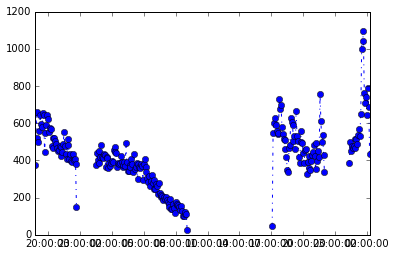

In [201]:
#first look at plots (notice the blanks)
plt.pyplot.plot_date(data.index, data['positive'], ls = 'dashdot')

In [35]:
#removes 
data['sum'] = sum([data['negative'],data['positive'],data['neutral']])
data = data.ix[data['sum'] > 0, ['negative','neutral','positive']]
data.head()

sentiment,negative,neutral,positive
2015-11-28 18:45:00+00:00,499,191,373
2015-11-28 18:50:00+00:00,700,372,508
2015-11-28 18:55:00+00:00,722,352,660
2015-11-28 19:00:00+00:00,641,335,520
2015-11-28 19:05:00+00:00,637,323,498


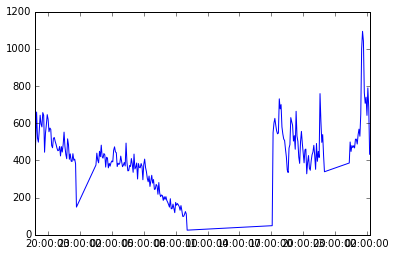

In [42]:
plt.pyplot.plot_date(data.index, data['positive'], ls = '-', ms = 0)


In [46]:
plt.figure(figsize=(12, 14))  

TypeError: 'module' object is not callable

In [47]:
import plotly

ImportError: No module named plotly